In [1]:
%load_ext autoreload
%autoreload 2
import time
import copy
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F

from utils.metrics import AverageMeter, accuracy
from figure import plot_classes_preds
from torchsummaryX import summary

from utils.utils import show_test_acc, show_profile, configuration
from dataset import get_dataloader, get_test_dataloader
from models.model import get_network
import matplotlib.pyplot as plt

In [2]:
cfg, writer = configuration('default_r18.yml', '0', jupyter=True)


**********START LOGGING, GPU: 0 **********



In [5]:
network = get_network(cfg['network'], 100)
state_dict_path = 'models/pretrained/resnet18_cifar100.pt'
network.load_state_dict(torch.load(state_dict_path),  strict=False)

target_trained_network = get_network(cfg['network'], 100)
target_state_dict_path = 'models/pretrained/resnet18_cifar100_01234.pt'
target_trained_network.load_state_dict(torch.load(target_state_dict_path),  strict=False)

[ NETWORK ]  resnet34
[MODEL] Number of parameters :  21328292
[ NETWORK ]  resnet34
[MODEL] Number of parameters :  21328292


<All keys matched successfully>

In [6]:
dataloader, n_class = get_dataloader(cfg)
get_test_dataloader(cfg, dataloader, get_only_targets=True)

for_trainNval :     CIFAR100
Cifar100 Dataloader
Files already downloaded and verified
Files already downloaded and verified
DATALOADER FOR CLASS:  [95, 96, 97, 98, 99]


In [5]:
# inputs, labels = next(iter(dataloader.train_loader))

In [7]:
#################
# 
def get_inputs(dataloader):
    labels =  torch.zeros(100)
    inputs = torch.zeros(100, 3, 32, 32)
    class_idx = 0
    for i, l in dataloader.train_loader:

        if class_idx in l:
            idx = (l == class_idx).nonzero(as_tuple=True)[0][0].item()
            inputs[class_idx] = i[idx]
            labels[class_idx] = l[idx]
            class_idx += 1

        if class_idx >= 100:
            print("Done!")
            break
    return inputs

def get_output(network, layer_idx, inputs):
    
    out = F.relu(network.bn1(network.conv1(inputs)))
    if layer_idx - 33 >= 0:
        print("이건 안돼")

    elif layer_idx - 27 >= 0:
        # layer4 : 27~32
        out = network.layer1(out)
        out = network.layer2(out)
        out = network.layer3(out)
        block_idx = (layer_idx-27)//2
        for i in range(block_idx):
            out = network.layer4[i](out)
        layer = network.layer4[block_idx]

        conv_idx = (layer_idx-27)%2
        out2 = F.relu(layer.bn1(layer.conv1(out)))
        if conv_idx > 0:
            out2 = layer.bn2(layer.conv2(out2))
            if layer.downsample:
                out2 += layer.downsample(out)
                out = F.relu(out2)
            else:
                out = out2

        print(f"[layer4]   block{block_idx}  conv{conv_idx+1}")

    elif layer_idx - 15 >= 0:
        # layer3 : 15~26
        out = network.layer1(out)
        out = network.layer2(out)
        block_idx = (layer_idx-15)//2
        for i in range(block_idx):
            out = network.layer3[i](out)
        layer = network.layer3[block_idx]

        conv_idx = (layer_idx-15)%2
        out2 = F.relu(layer.bn1(layer.conv1(out)))
        if conv_idx > 0:
            out2 = layer.bn2(layer.conv2(out2))
            if layer.downsample:
                out2 += layer.downsample(out)
                out = F.relu(out2)
            else:
                out = out2
                
        print(f"[layer3]   block{block_idx}  conv{conv_idx+1}")

    elif layer_idx - 7 >= 0:
        # layer2 : 7~14
        out = network.layer1(out)
        block_idx = (layer_idx-7)//2
        for i in range(block_idx):
            out = network.layer2[i](out)
        layer = network.layer2[block_idx]

        conv_idx = (layer_idx-7)%2
        out2 = F.relu(layer.bn1(layer.conv1(out)))
        if conv_idx > 0:
            out2 = layer.bn2(layer.conv2(out2))
            if layer.downsample:
                out2 += layer.downsample(out)
                out = F.relu(out2)
            else:
                out = out2

        print(f"[layer2]   block{block_idx}  conv{conv_idx+1}")
    elif layer_idx - 1 >= 0:
        # layer1 : 1~6
        block_idx = (layer_idx-1)//2
        for i in range(block_idx):
            out = network.layer1[i](out)
        layer = network.layer1[block_idx]

        conv_idx = (layer_idx-1)%2
        out2 = F.relu(layer.bn1(layer.conv1(out)))
        if conv_idx > 0:
            out2 = layer.bn2(layer.conv2(out2))
            if layer.downsample:
                out2 += layer.downsample(out)
                out = F.relu(out2)
            else:
                out = out2

        print(f"[layer1]   block{block_idx}  conv{conv_idx+1}")
    return out

In [8]:
inputs = get_inputs(dataloader)

In [9]:
# layer_idx = 10  # 0~33
# out = get_output(network, layer_idx, inputs)  # (100, 256, 8, 8)
# norm = torch.norm(out, dim=(2,3)).detach().numpy()  # (100, 256)
# ranks = np.argsort(norm, 1) # 가장 작은 값을 가진 필터가 0, 가장 큰 값일수록 등수가 높다
# # 차이 없어야 정상
# plt.matshow(ranks)

In [10]:
# plt.imshow(out.detach().numpy()[0,0,:,:])
# plt.imshow(inputs.detach().numpy()[0,0,:,:])

In [11]:
# # inputs = get_inputs(dataloader)
# target_trained_out = get_output(target_trained_network, layer_idx, inputs)
# target_norm = torch.norm(target_trained_out, dim=(2,3)).detach().numpy()  # (100, 256)
# target_ranks = np.argsort(target_norm, 1) # 가장 작은 값을 가진 필터가 0, 가장 큰 값일수록 등수가 높다
# plt.matshow(target_ranks)

In [12]:
# # 차이 있어야 정상
# """
# 순위차: 원래 모델에서의 순위- target class로만 학습한 모델에서의 순위
# 0~4 class: 순위차가 있어야함
# 나머지: 순위차가 있어야함
# """
# diff = target_ranks-ranks
# plt.matshow(diff)

In [13]:
r_alls = []
r_targets = []
r_targets09 = []

[layer1]   block0  conv1
[layer1]   block0  conv2
[layer1]   block1  conv1
[layer1]   block1  conv2
[layer1]   block2  conv1
[layer1]   block2  conv2
[layer2]   block0  conv1
[layer2]   block0  conv2
[layer2]   block1  conv1
[layer2]   block1  conv2
[layer2]   block2  conv1
[layer2]   block2  conv2
[layer2]   block3  conv1
[layer2]   block3  conv2
[layer3]   block0  conv1
[layer3]   block0  conv2
[layer3]   block1  conv1
[layer3]   block1  conv2
[layer3]   block2  conv1
[layer3]   block2  conv2
[layer3]   block3  conv1
[layer3]   block3  conv2
[layer3]   block4  conv1
[layer3]   block4  conv2
[layer3]   block5  conv1
[layer3]   block5  conv2
[layer4]   block0  conv1
[layer4]   block0  conv2
[layer4]   block1  conv1
[layer4]   block1  conv2
[layer4]   block2  conv1
[layer4]   block2  conv2
이건 안돼


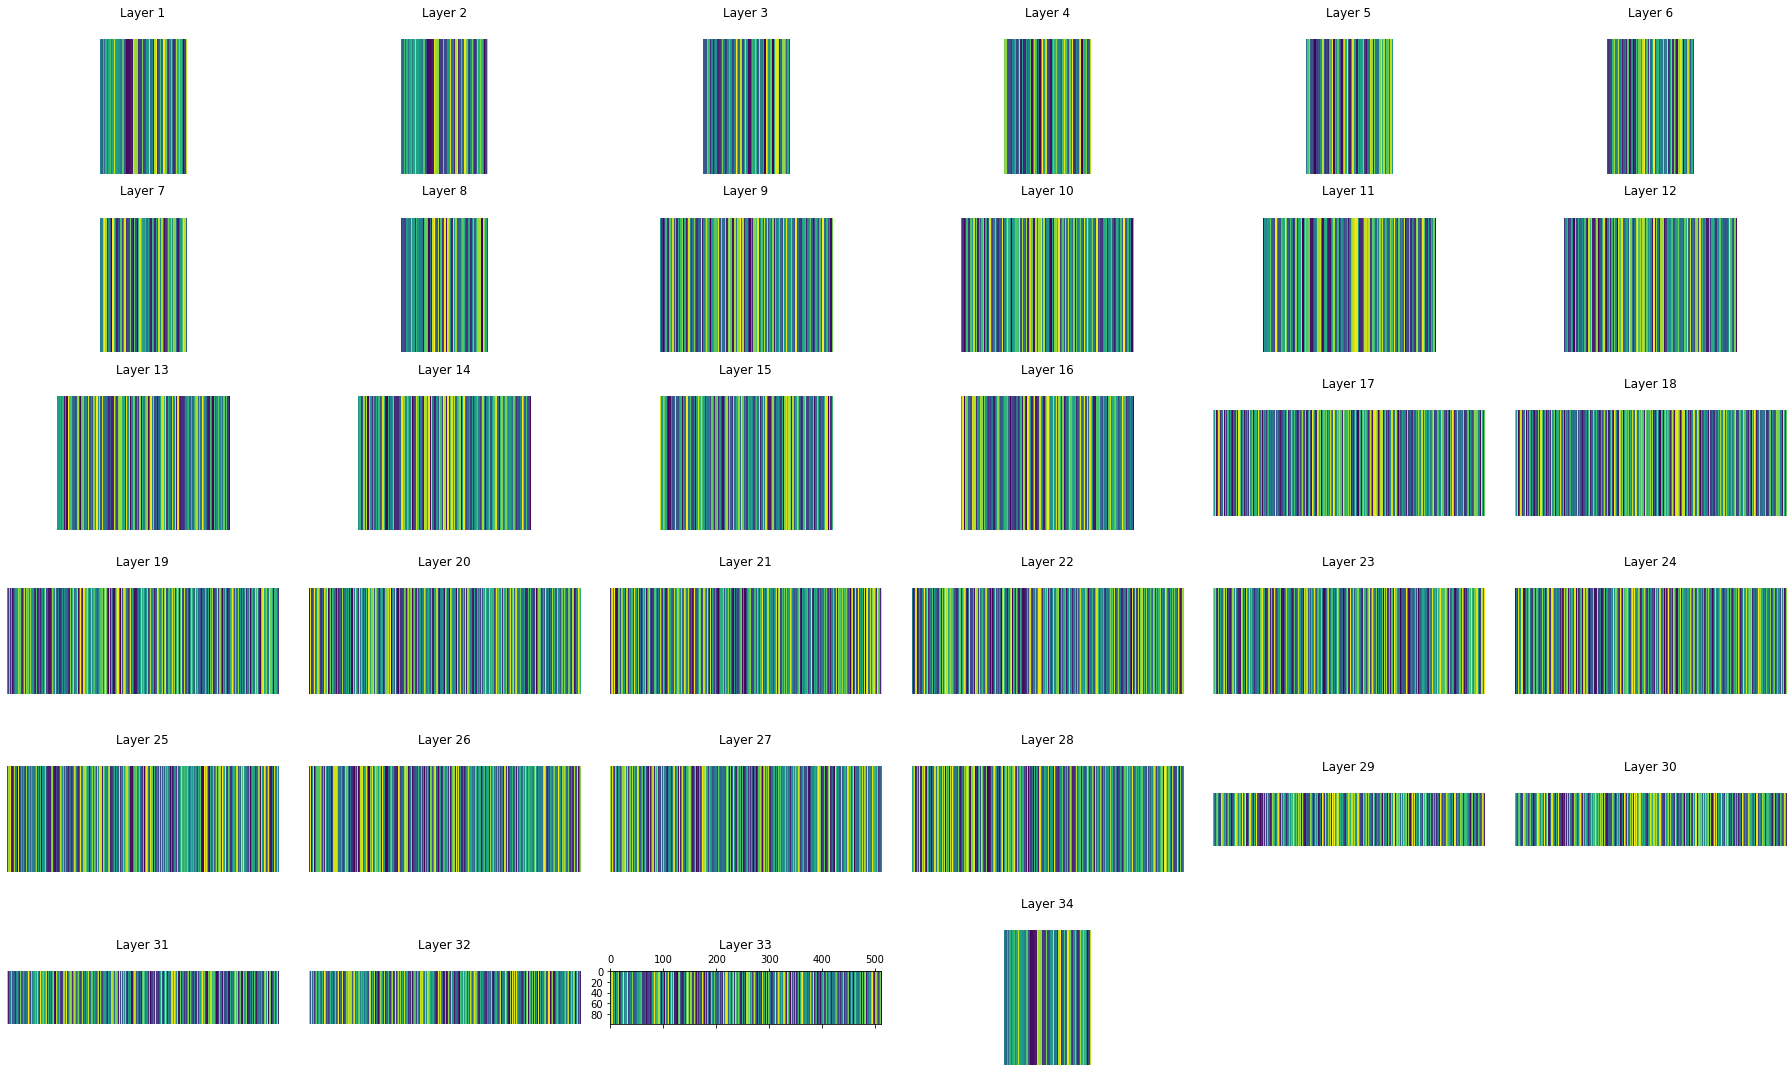

In [21]:
plt.figure(figsize=(25, 15)) 
for layer_idx in range(34):
    plt.subplot(6,6, layer_idx+1)
    if layer_idx != 32:
        plt.axis('off')
        
    out = get_output(network, layer_idx, inputs)  # (100, 256, 8, 8)
    norm = torch.norm(out, dim=(2,3)).detach().numpy()  # (100, 256)
    ranks = np.argsort(norm, 1) # 가장 작은 값을 가진 필터가 0, 가장 큰 값일수록 등수가 높다
    # 차이 없어야 정상
    r_alls.append(ranks)
    plt.matshow(ranks, fignum=False)
    plt.title(f'Layer {layer_idx+1}')
    
plt.tight_layout()
plt.savefig('figures/all_trained_fm.png')
plt.show()

[layer1]   block0  conv1
[layer1]   block0  conv2
[layer1]   block1  conv1
[layer1]   block1  conv2
[layer1]   block2  conv1
[layer1]   block2  conv2
[layer2]   block0  conv1
[layer2]   block0  conv2
[layer2]   block1  conv1
[layer2]   block1  conv2
[layer2]   block2  conv1
[layer2]   block2  conv2
[layer2]   block3  conv1
[layer2]   block3  conv2
[layer3]   block0  conv1
[layer3]   block0  conv2
[layer3]   block1  conv1
[layer3]   block1  conv2
[layer3]   block2  conv1
[layer3]   block2  conv2
[layer3]   block3  conv1
[layer3]   block3  conv2
[layer3]   block4  conv1
[layer3]   block4  conv2
[layer3]   block5  conv1
[layer3]   block5  conv2
[layer4]   block0  conv1
[layer4]   block0  conv2
[layer4]   block1  conv1
[layer4]   block1  conv2
[layer4]   block2  conv1
[layer4]   block2  conv2
이건 안돼


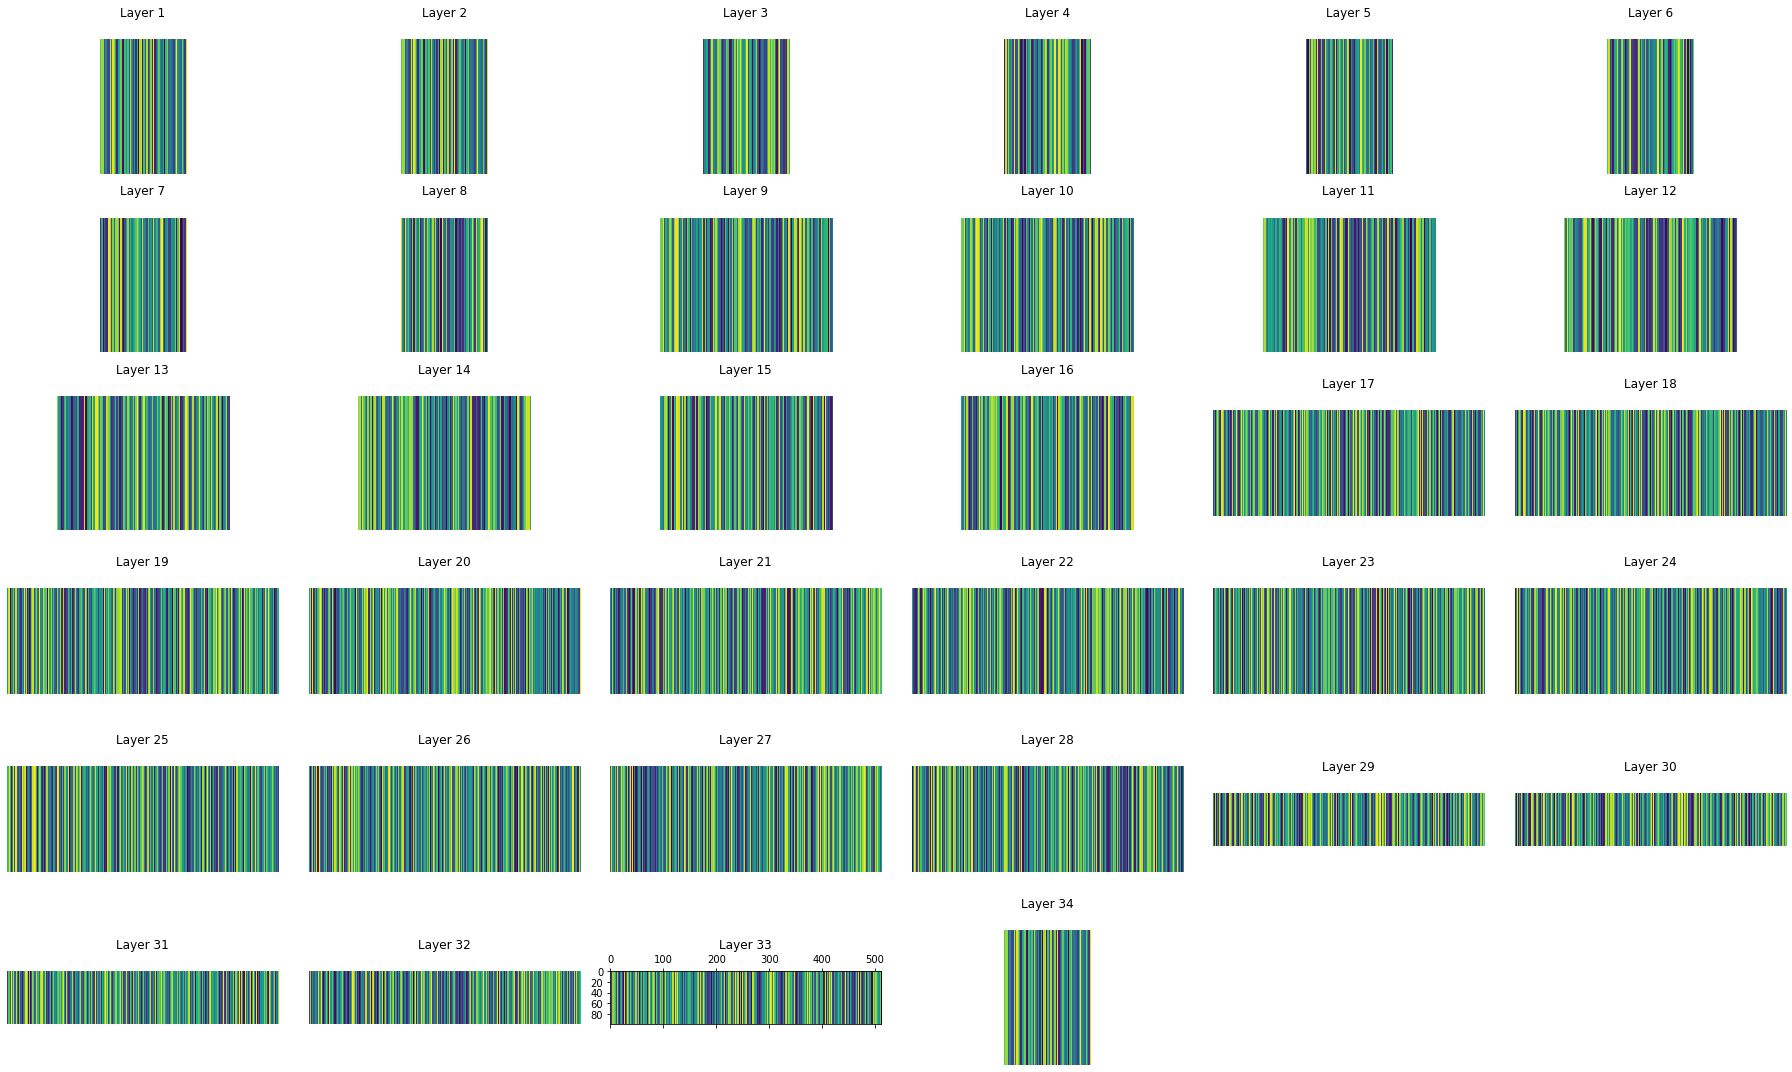

In [22]:
plt.figure(figsize=(25, 15)) 
for layer_idx in range(34):
    plt.subplot(6,6, layer_idx+1)
    if layer_idx != 32:
        plt.axis('off')
        
    target_trained_out = get_output(target_trained_network, layer_idx, inputs)
    target_norm = torch.norm(target_trained_out, dim=(2,3)).detach().numpy()  # (100, 256)
    target_ranks = np.argsort(target_norm, 1) # 가장 작은 값을 가진 필터가 0, 가장 큰 값일수록 등수가 높다
    
    r_targets.append(target_ranks)
    plt.matshow(target_ranks, fignum=False)
    plt.title(f'Layer {layer_idx+1}')
    
plt.tight_layout()
plt.savefig('figures/target_trained_fm.png')
plt.show()

/opt/conda/envs/DI/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/DI/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/DI/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` 

/opt/conda/envs/DI/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/DI/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/DI/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` 

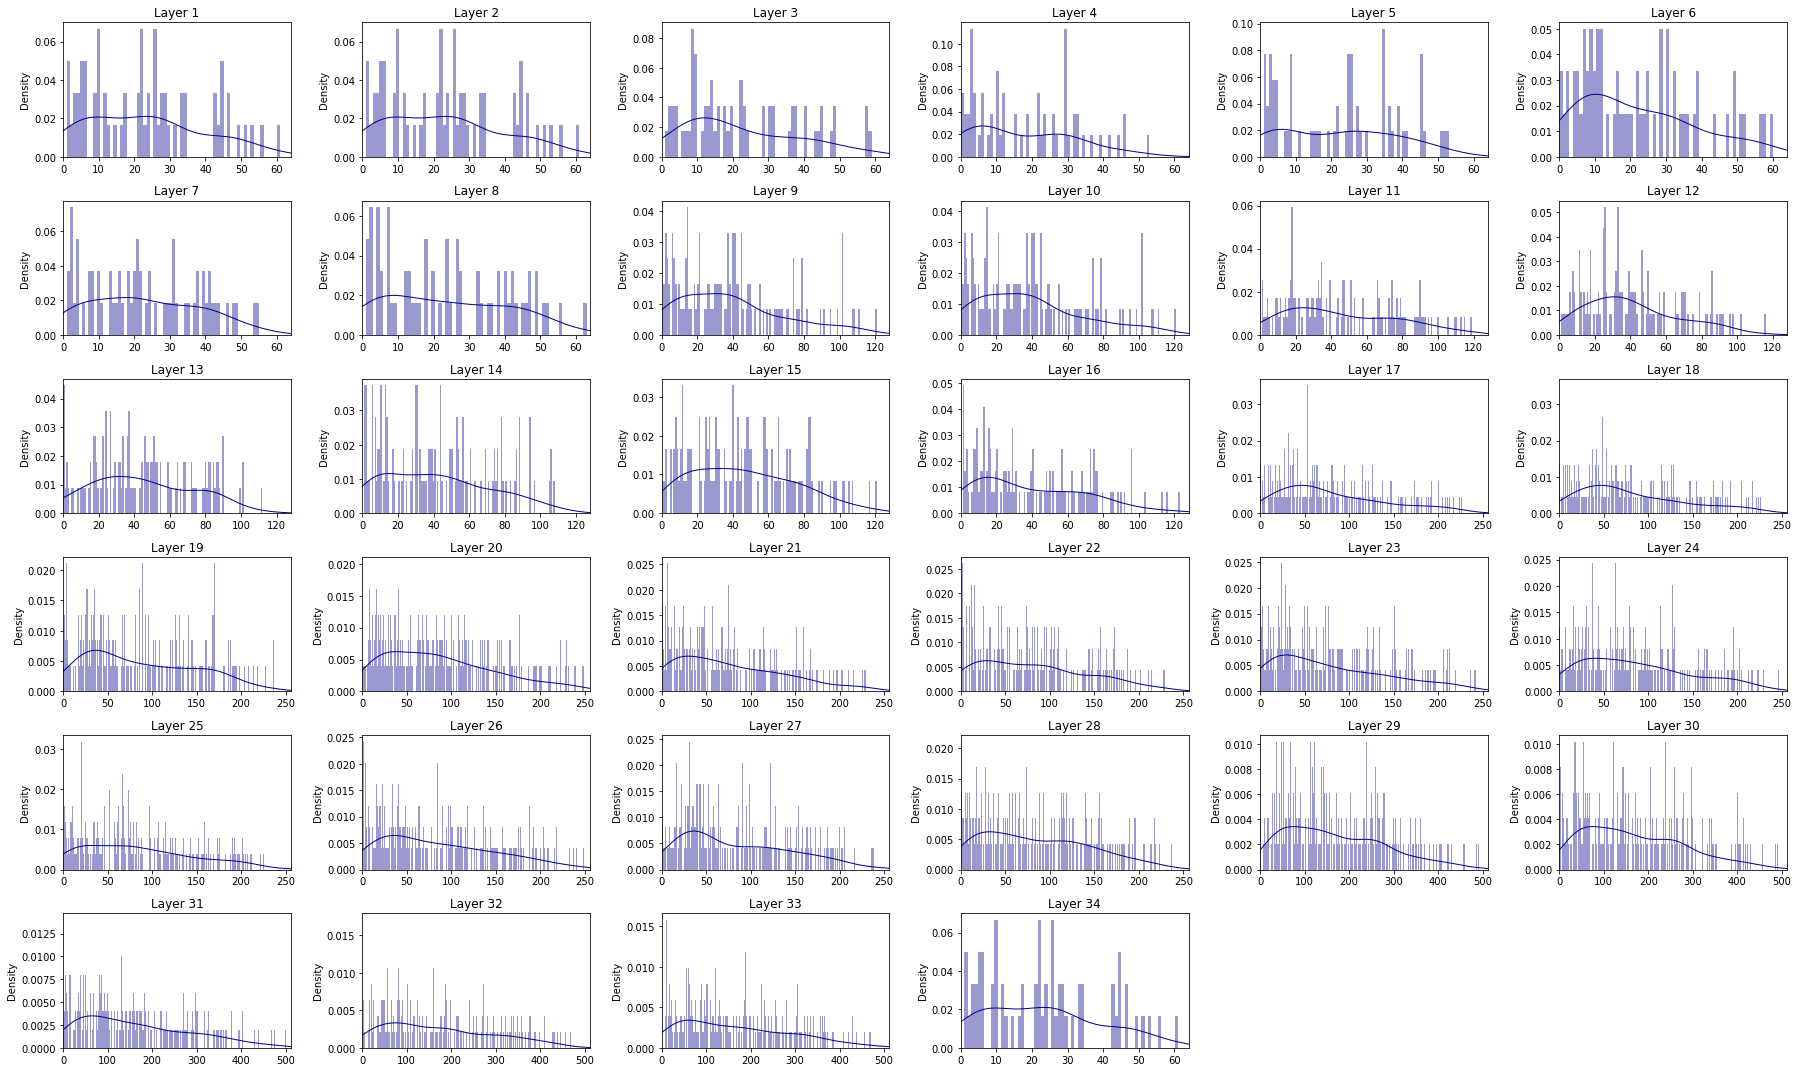

In [17]:
import seaborn as sns

plt.figure(figsize=(25, 15)) 
for layer_idx, (a, t) in enumerate(zip(r_alls, r_targets)):
    plt.subplot(6,6, layer_idx+1)
#     if layer_idx != 32:
#         plt.axis('off')
        
    diff = np.mean(np.abs(t-a), axis=0)
    sns.distplot(diff, hist=True, kde=True, 
                 bins=int(len(diff)), color = 'darkblue', 
                 kde_kws={'linewidth': 1})
    
    plt.xlim(0, len(diff))
    plt.title(f'Layer {layer_idx+1}')
    
plt.tight_layout()

plt.savefig('figures/diff_histogram.png')
plt.show()

In [18]:
sam = np.abs(r_targets[0]-r_alls[0])
sam = np.mean(sam, axis=0)
sam

array([17., 34., 10.,  5., 13., 10., 26., 15.,  2., 23.,  6.,  1., 29.,
        5.,  6., 22., 43., 45., 27., 31., 43., 12., 53., 26., 49., 21.,
       45., 12.,  9., 44., 46., 46., 30.,  1., 22., 26., 34., 28., 22.,
       56., 51., 45., 28., 29., 16.,  1., 24., 61.,  6., 33., 10.,  4.,
       26.,  5.,  4., 22.,  9., 10., 24., 21., 17., 33.,  3.,  3.])

In [19]:
sam.shape

(64,)

/opt/conda/envs/DI/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 60.0)

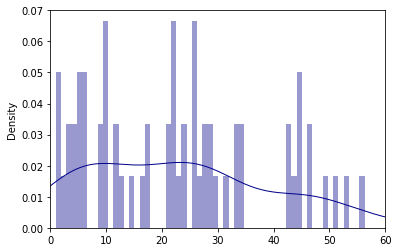

In [20]:

import seaborn as sns

sns.distplot(sam, hist=True, kde=True, 
             bins=int(len(sam)), color = 'darkblue', 
             kde_kws={'linewidth': 1})
plt.xlim(0, 60)

In [ ]:

# plt.figure(figsize=(25, 15)) 
# for layer_idx, (a, t) in enumerate(zip(r_alls, r_targets)):
#     plt.subplot(6,6, layer_idx+1)
#     if layer_idx != 32:
#         plt.axis('off')
        
#     diff = np.abs(t-a)
#     plt.matshow(diff, fignum=False)
#     plt.title(f'Layer {layer_idx+1}')
    
# plt.tight_layout()
# # 절댓값으로도 해보기
# # 맥스 일정하게 같은 값이면 같은 색으로 보이게

# plt.savefig('figures/diff.png')
# plt.show()

In [ ]:

target09_trained_network = get_network(cfg['network'], 100)
target09_state_dict_path = 'models/pretrained/resnet34_cifar100_0~9.pt'
target09_trained_network.load_state_dict(torch.load(target09_state_dict_path),  strict=False)

In [ ]:
plt.figure(figsize=(25, 15)) 
for layer_idx in range(34):
    plt.subplot(6,6, layer_idx+1)
    if layer_idx != 32:
        plt.axis('off')
        
    target09_trained_out = get_output(target09_trained_network, layer_idx, inputs)
    target_norm = torch.norm(target09_trained_out, dim=(2,3)).detach().numpy()  # (100, 256)
    target_ranks = np.argsort(target_norm, 1) # 가장 작은 값을 가진 필터가 0, 가장 큰 값일수록 등수가 높다
    
    r_targets09.append(target_ranks)
    plt.matshow(target_ranks, fignum=False)
    plt.title(f'Layer {layer_idx+1}')
    
plt.tight_layout()
plt.savefig('figures/target09_trained_fm.png')
plt.show()

In [ ]:

plt.figure(figsize=(25, 15)) 
for layer_idx, (a, t) in enumerate(zip(r_alls, r_targets)):
    plt.subplot(6,6, layer_idx+1)
    if layer_idx != 32:
        plt.axis('off')
        
    diff = np.abs(t-a)
    plt.matshow(diff, fignum=False)
    plt.title(f'Layer {layer_idx+1}')
    
plt.tight_layout()

plt.savefig('figures/diff_histogram.png')
plt.show()

In [ ]:
np.random.randint(0, 99, 5)